In [1]:
import cv2
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

In [2]:
caps = [cv2.VideoCapture(0, cv2.CAP_DSHOW), cv2.VideoCapture(1, cv2.CAP_DSHOW)]

In [2]:
baseline = 11.5 # in cm
desiredDistance = 70 # in cm
focal_length = 10

In [9]:
_, image1 = caps[0].read()
_, image2 = caps[1].read()
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


In [47]:
# Storing the images
plt.imsave("image1.png", image1)
plt.imsave("image2.png", image2)

In [3]:
# loading the images
image1 = plt.imread("image1.png")
image2 = plt.imread("image2.png")

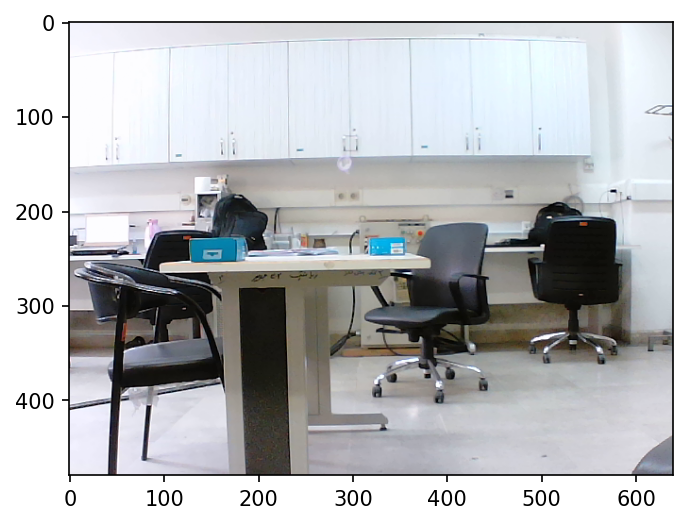

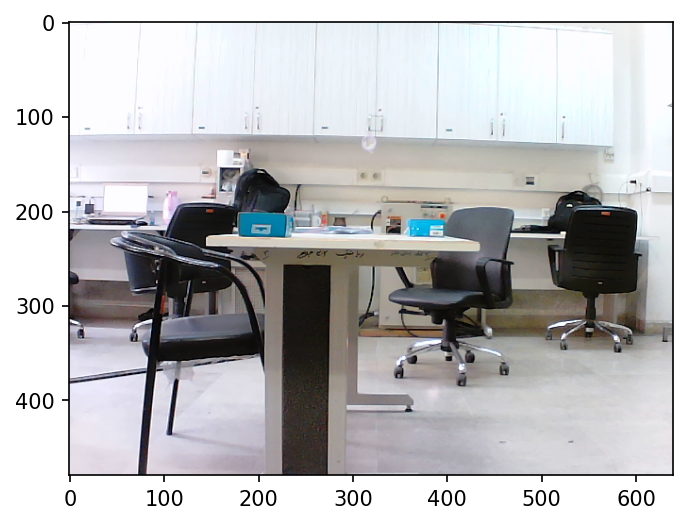

In [4]:
plt.figure(dpi=150)
plt.imshow(image1)
plt.figure(dpi=150)
plt.imshow(image2)

In [5]:
class calibrator:
    
    def __init__(self, calibration_data:str):
        with open(calibration_data,'rb') as f:
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs, self.w, self.h= pkl.load(f)
            self.newcameramtx, self.roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (self.w,self.h), 1, (self.w,self.h))

    def undistort(self, img:np.ndarray)->np.ndarray:
        dst = cv2.undistort(img, self.mtx, self.dist, None, self.newcameramtx)
        x, y, w, h = self.roi
        return dst[y:y+h, x:x+w]
        # return dst

calib1 = calibrator("../calibration objects/cam1_calib.pkl") # Calibarion object for camera 1
calib2 = calibrator("../calibration objects/cam2_calib.pkl") # Calibarion object for camera 2

In [6]:
class Stereo:
    '''
    A class for extracting the 3d location of objects using their 2d locations in images.
    '''
    def __init__(self, b:int, f:int, disparity_shift = 0):
        '''
        Args:
            b (int): the distance between the center of the cameras in any unit
            f (float): focal point of the cameras
            disparity_shift (int): shift in the disparity caused by camera calibraion. must be derived from the setup. default is 0.
        '''
        self.b = b
        self.f = f
        self.disparity_shift = disparity_shift
    
    def locate(self, p1:tuple, p2:tuple)->tuple:
        self.disparity = abs(p1[0] - p2[0] + self.disparity_shift) # d = X1 - X2 + Ds
        self.z = (self.b * self.f) / self.disparity # Z = f * B / d
        self.x = p1[0] * self.z / self.f # X = X1 * Z / f
        self.y = (p1[1] + p2[1]) * self.z / self.f
        return (self.x, self.y, self.z)

# Measurements before calibarting and undistroting images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


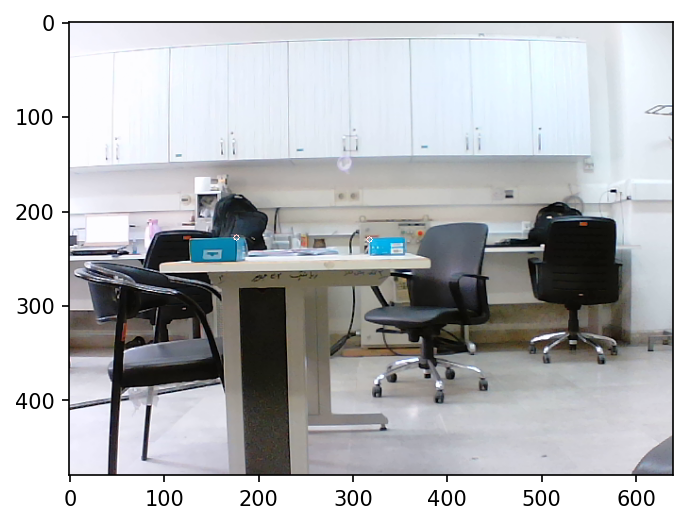

In [21]:
imagePoints1 = [(177, 228), (318, 230)]
imageCopy1 = image1.copy()
for point in imagePoints1:
    cv2.circle(imageCopy1, point, 3, (255, 0, 0), 1)
plt.figure(dpi=150)
plt.imshow(imageCopy1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


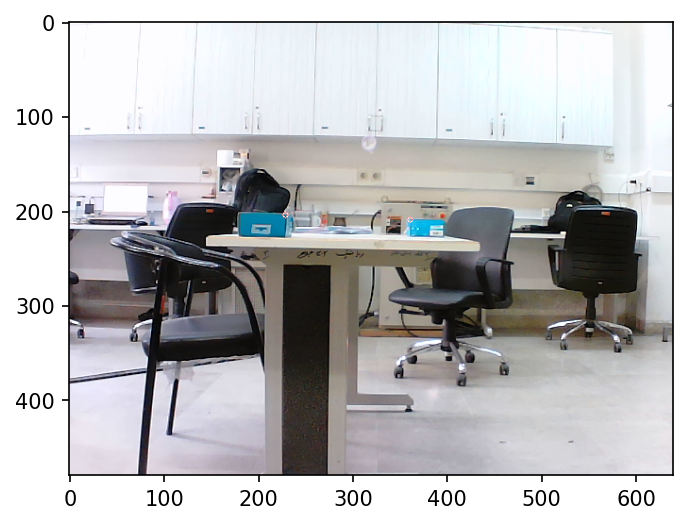

In [22]:
imagePoints2 = [(229, 204), (361, 209)]
imageCopy2 = image2.copy()
for point in imagePoints2:
    cv2.circle(imageCopy2, point, 3, (255, 0, 0), 1)
plt.figure(dpi=150)
plt.imshow(imageCopy2)

In [29]:
# Centering the pixel coordinates
midy = image1.shape[0] / 2 # the exact value must ber measured
midx = image1.shape[1] / 2 # the exact value must ber measured

imagePointsCentered1 = [(p[0] - midx, p[1] - midy) for p in imagePoints1] 
imagePointsCentered2 = [(p[0] - midx, p[1] - midy) for p in imagePoints2]

In [56]:
stereo = Stereo(baseline, 1080, 0)

locations = [stereo.locate(imagePointsCentered1[0], imagePointsCentered2[0]), stereo.locate(imagePointsCentered1[1], imagePointsCentered2[1])]
print(f"Locations:\n{locations}")
dx = locations[0][0] - locations[1][0]
dy = locations[0][1] - locations[1][1]
dz = locations[0][2] - locations[1][2]
distance = (dx ** 2 + dy ** 2) ** 0.5
print(f"dx :\t\t{dx}")
print(f"dy :\t\t{dy}")
print(f"dz :\t\t{dz}")
print(f"distance :\t{distance}")

Locations:
[(-31.625, -10.615384615384615, 238.84615384615384), (-0.5348837209302325, -10.965116279069766, 288.83720930232556)]
dx :		-31.09011627906977
dy :		0.3497316636851515
dz :		-49.99105545617172
distance :	31.092083276658432


# Measurements after calibarting and undistroting images

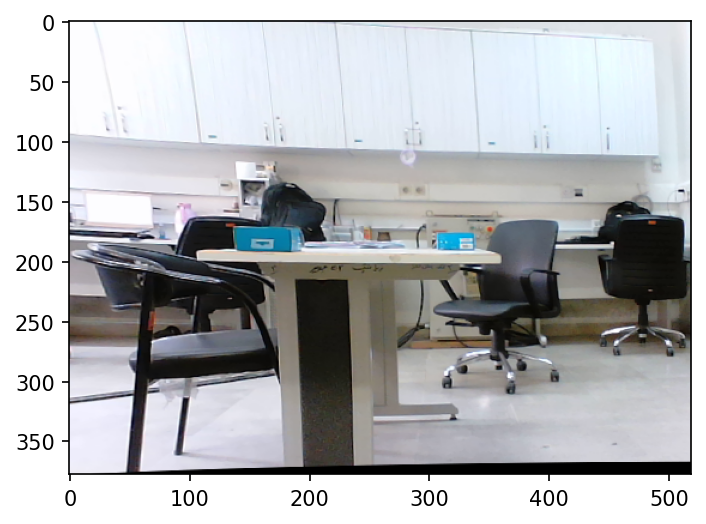

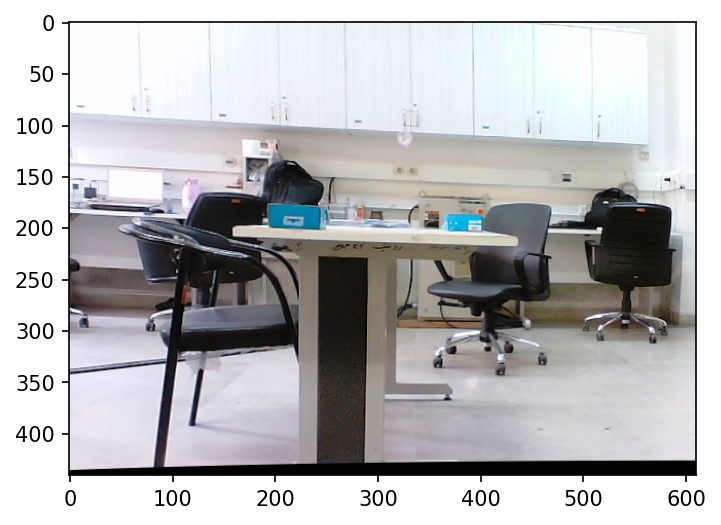

In [41]:
undistortedImage1 = calib1.undistort(image1)
undistortedImage2 = calib2.undistort(image2)
plt.figure(dpi=150)
plt.imshow(undistortedImage1)
plt.figure(dpi=150)
plt.imshow(undistortedImage2)

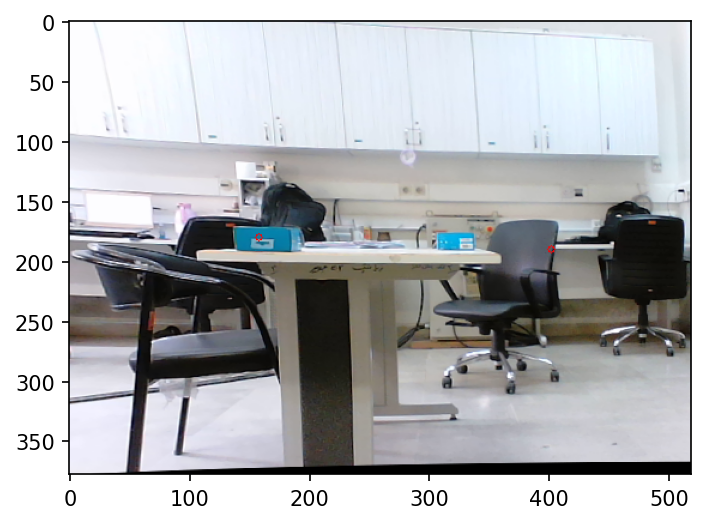

In [42]:
undistortedImagePoints1 = [(158, 180), (402, 190)]
imageCopy1 = undistortedImage1.copy()
for point in undistortedImagePoints1:
    cv2.circle(imageCopy1, point, 3, (255, 0, 0), 1)
plt.figure(dpi=150)
plt.imshow(imageCopy1)

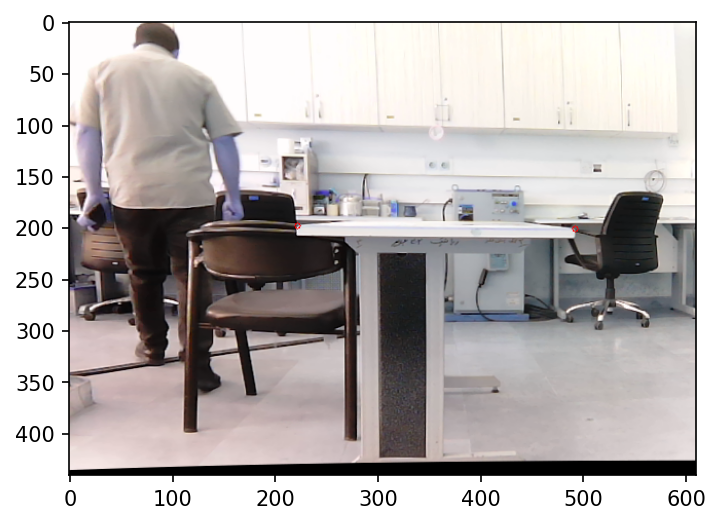

In [41]:
undistortedImagePoints2 = [(222, 198), (492, 201)]
imageCopy2 = undistortedImage2.copy()
for point in undistortedImagePoints2:
    cv2.circle(imageCopy2, point, 3, (255, 0, 0), 1)
plt.figure(dpi=150)
plt.imshow(imageCopy2)

In [96]:
undistortedStereo = Stereo(11.2, 1, 46.5)
undsitortedLocations = [undistortedStereo.locate(undistortedImagePoints1[0], undistortedImagePoints2[0]), undistortedStereo.locate(undistortedImagePoints1[1], undistortedImagePoints2[1])]
print(f"Undistorted Locations:\n{undsitortedLocations}")
undistortedDx = undsitortedLocations[0][0] - undsitortedLocations[1][0]
undistortedDy = undsitortedLocations[0][1] - undsitortedLocations[1][1]
undistortedDistance = (undistortedDx ** 2 + undistortedDy ** 2) ** 0.5
print(f"dx :\t\t{undistortedDx}")
print(f"dy :\t\t{undistortedDy}")
print(f"distance :\t{undistortedDistance}")

Undistorted Locations:
[(101.11999999999999, 120.95999999999998, 0.64), (103.50344827586206, 50.33563218390803, 0.2574712643678161)]
dx :		-2.383448275862065
dy :		70.62436781609195
distance :	70.664574965865


In [106]:
stereo = Stereo(11.2, 10, 46.5)
locations = [stereo.locate(undistortedImagePoints1[0], undistortedImagePoints2[0]), stereo.locate(undistortedImagePoints1[1], undistortedImagePoints2[1])]
print(f"Locations:\n{locations}")
dx = locations[0][0] - locations[1][0]
dy = locations[0][1] - locations[1][1]
distance = (dx ** 2 + dy ** 2) ** 0.5
print(f"dx :\t\t{dx}")
print(f"dy :\t\t{dy}")
print(f"distance :\t{distance}")

Locations:
[(101.11999999999999, 120.95999999999998, 6.4), (103.50344827586206, 50.33563218390803, 2.574712643678161)]
dx :		-2.383448275862065
dy :		70.62436781609195
distance :	70.664574965865
